# Monet style-transfer with CycleGAN 

In this notebook, I will implement a CycleGAN (Cycle-Consistent Generative Adversarial Network) model to translate photographs into "fake" Monet paintings for Kaggle's [I'm Something of a Painter Myself](https://www.kaggle.com/competitions/gan-getting-started/discussion) competition.  

The goal of the Kaggle competition is to generate between 7k-10k novel images that stylistically similar to the works of Claude Monet, the influential French painter.  Contest submissions are scored by a modified FID metric that represents the similarity between extracted feature distributions of the "fake" submission images and Monet's "real" paintings.  The FID is modified to penalize submissions where the "fake" images are extremely similar to each other (which would indicate ["mode collapse"](https://developers.google.com/machine-learning/gan/problems)).

Out of the many viable approachs to this task, I chose to use a [CycleGAN](https://arxiv.org/abs/1703.10593).  



In [ ]:
%%capture
! pip install tensorflow_addons

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow import keras
from tensorflow.keras import layers, models

%matplotlib inline

# Load data

Data is available at https://www.kaggle.com/competitions/gan-getting-started/data

Note: this notebook was developed in Google Colab but competition submissions must be generated from a Kaggle kernel.  Kaggle filepaths are included, but commented out.  

* If running this notebook on Google Colab, you can use the following code block to download (and extract) the dataset from Kaggle.  

* If running this notebook on Kaggle, ignore the following code block and uncomment the Kaggle filepaths (ctrl+f "Kaggle path" to find the 3 relevant lines)

## Colab: download data from Kaggle

In [ ]:
import os
os.environ['KAGGLE_USERNAME'] = "USERNAME" # kaggle username
os.environ['KAGGLE_KEY'] = "KEY" # kaggle api key
! kaggle competitions download -c gan-getting-started
! mkdir input
! unzip /content/gan-getting-started.zip -d input # Colab path

# Load data as tf.data.datasets
The dataset contains 300 Monets and 7038 photos.  

The images are provided in jpg and tfrec data formats.  Images are 256x256 pixels with rgb values (shape= (256,256,3)).  Pixel values are encoded as integers between [0,255]

In [ ]:
batch_size = 1

monet_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/input/monet_jpg", # Colab path
    # "../input/gan-getting-started/monet_jpg", # Kaggle path
    labels=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(256, 256),
    shuffle=True,
    seed=1,
    crop_to_aspect_ratio=False)

photo_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/input/photo_jpg", # Colab path
    # "../input/gan-getting-started/photo_jpg", # Kaggle path
    labels=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(256, 256),
    shuffle=True,
    seed=1,
    crop_to_aspect_ratio=False)

Found 300 files belonging to 1 classes.
Found 7038 files belonging to 1 classes.


In [ ]:
autotune = tf.data.AUTOTUNE
buffer_size = 256
input_img_size = (256, 256, 3)

# normalize pixel values
monet_ds = (
    monet_ds.map(lambda x: x/127.5 - 1, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size))
photo_ds = (
    photo_ds.map(lambda x: x/127.5 - 1, num_parallel_calls=autotune)
    .cache()
    .shuffle(buffer_size))

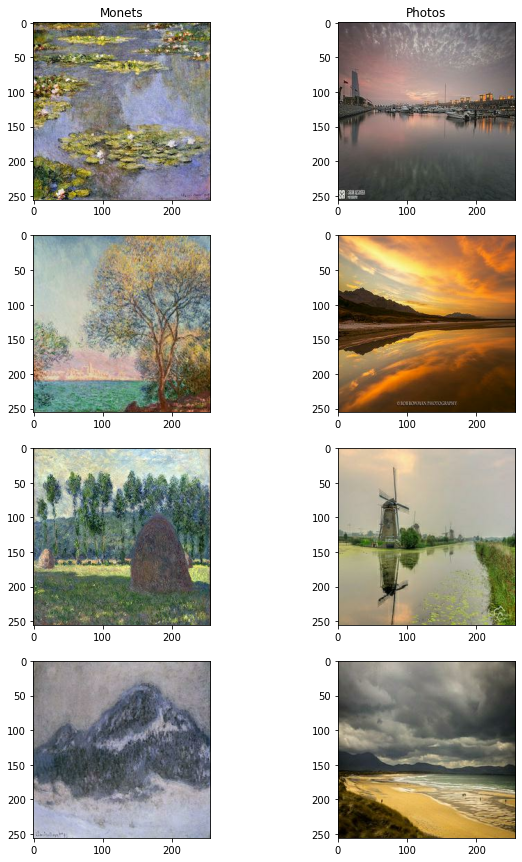

In [ ]:
# display example Monet and Photo files
_, ax = plt.subplots(4, 2, figsize=(10, 15))
for i, samples in enumerate(zip(monet_ds.take(4), photo_ds.take(4))):
    monet = (((samples[0] * 127.5) + 127.5).numpy()).astype(np.uint8)[0,:,:,:]
    photo = (((samples[1] * 127.5) + 127.5).numpy()).astype(np.uint8)[0,:,:,:]
    ax[i, 0].imshow(monet)
    ax[i, 1].imshow(photo)
ax[0,0].set_title("Monets")
ax[0,1].set_title("Photos")
plt.show()

---
# CycleGAN model

GANs are made of a generator and a discriminator placed in direct competition.  For this task, a generator would try to make a "fake" Monet that are able to fool the discriminator into misclassifying the "fake" Monet as a "real" one.

CycleGANs are a GAN variant that have 2 Generators and 2 Discriminators.  One generator translates photos to Monets while the other generator translates Monets into photos.  One discriminator tries to classify photos as "real" or "fake" (generated) while the other discrimintor classifies Monets as "real" or "fake".  

During a training step, each generator translates both a "real" image from the training dataset *and* the "fake" image produced by the opposite generator.   This is where the concept of "cycle" comes into play, since each training is used to produce a "fake" image which is converted back to be as similar as possible to the original training image.

At the end of training there are four components to the model which can be used independently: two image generators and two discriminators.  But for this task, I only need the Monet image generator after training is finished.

## CycleGAN building blocks

In [ ]:
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

# modified from https://keras.io/examples/generative/cyclegan/
class ReflectionPadding2D(layers.Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def call(self, input_tensor, mask=None):
        padding_width, padding_height = self.padding
        padding_tensor = [
            [0, 0],
            [padding_height, padding_height],
            [padding_width, padding_width],
            [0, 0],
        ]
        return tf.pad(input_tensor, padding_tensor, mode="REFLECT")


def residual_block(
    x,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="valid",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    dim = x.shape[-1]
    input_tensor = x

    x = ReflectionPadding2D()(input_tensor)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = activation(x)

    x = ReflectionPadding2D()(x)
    x = layers.Conv2D(
        dim,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    x = layers.add([input_tensor, x])
    return x


def downsample(
    x,
    filters,
    activation,
    kernel_initializer=kernel_init,
    kernel_size=(4, 4),
    strides=(2, 2),
    padding="same",
    gamma_initializer=gamma_init,
    use_bias=False,
):
    x = layers.Conv2D(
        filters,
        kernel_size,
        strides=strides,
        kernel_initializer=kernel_initializer,
        padding=padding,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

##upsampling by stride=2 transposed convolutions
# def upsample(
#     x,
#     filters,
#     activation,
#     kernel_size=(3, 3),
#     strides=(2, 2),
#     padding="same",
#     kernel_initializer=kernel_init,
#     gamma_initializer=gamma_init,
#     use_bias=False,
# ):
#     x = layers.Conv2DTranspose(
#         filters,
#         kernel_size,
#         strides=strides,
#         padding=padding,
#         kernel_initializer=kernel_initializer,
#         use_bias=use_bias,
#     )(x)
#     x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
#     if activation:
#         x = activation(x)
#     return x


#upsample by resizing and then using a stride=1 convolution
# as described in https://distill.pub/2016/deconv-checkerboard/
def upsample(
    x,
    filters,
    activation,
    kernel_size=(3, 3),
    strides=(1, 1),
    padding="same",
    kernel_initializer=kernel_init,
    gamma_initializer=gamma_init,
    use_bias=False,
):

    img_size = x.shape[-2]
    x = tf.image.resize(images=x, method="nearest", size=[img_size*2,img_size*2])
    x = layers.Conv2DTranspose(
        filters,
        kernel_size,
        strides=strides,
        padding=padding,
        kernel_initializer=kernel_initializer,
        use_bias=use_bias,
    )(x)
    x = tfa.layers.InstanceNormalization(gamma_initializer=gamma_initializer)(x)
    if activation:
        x = activation(x)
    return x

## Build Generators


In [ ]:
# modified from https://keras.io/examples/generative/cyclegan/
def get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    gamma_initializer=gamma_init,
    name=None,
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = ReflectionPadding2D(padding=(3, 3))(img_input)
    x = layers.Conv2D(filters, (7, 7), kernel_initializer=kernel_init, use_bias=False)(
        x
    )
    x = layers.Activation("relu")(x)

    # Downsampling
    for _ in range(num_downsampling_blocks):
        filters *= 2
        x = downsample(x, filters=filters, activation=layers.LeakyReLU(0.2))

    # Residual blocks
    for _ in range(num_residual_blocks):
        x = residual_block(x, activation=layers.LeakyReLU(0.2))

    # Upsampling
    for _ in range(num_upsample_blocks):
        filters //= 2
        x = upsample(x, filters, activation=layers.LeakyReLU(0.2))

    # Final block
    x = ReflectionPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(3, (7, 7), padding="valid")(x)
    x = layers.Activation("tanh")(x)

    model = keras.models.Model(img_input, x, name=name)
    return model

In [ ]:
# Get the generators
gen_G = get_resnet_generator(name="generator_G") #Monet generator
gen_F = get_resnet_generator(name="generator_F") #photo generator

## Build Discriminators

In [ ]:
def get_discriminator(
    filters=64, kernel_initializer=kernel_init, num_downsampling=3, name=None
):
    img_input = layers.Input(shape=input_img_size, name=name + "_img_input")
    x = layers.Conv2D(
        filters,
        (4, 4),
        strides=(2, 2),
        padding="same",
        kernel_initializer=kernel_initializer,
    )(img_input)
    x = layers.LeakyReLU(0.2)(x)

    num_filters = filters
    for num_downsample_block in range(3):
        num_filters *= 2
        if num_downsample_block < 2:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(2, 2),
            )
        else:
            x = downsample(
                x,
                filters=num_filters,
                activation=layers.LeakyReLU(0.2),
                kernel_size=(4, 4),
                strides=(1, 1),
            )

    x = layers.Conv2D(
        1, (4, 4), strides=(1, 1), padding="same", kernel_initializer=kernel_initializer
    )(x)

    model = keras.models.Model(inputs=img_input, outputs=x, name=name)
    return model

In [ ]:
# Get the discriminators
disc_X = get_discriminator(name="discriminator_X")
disc_Y = get_discriminator(name="discriminator_Y")

## Build Model

In [ ]:
# modified from https://keras.io/examples/generative/cyclegan/
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_G,
        generator_F,
        discriminator_X,
        discriminator_Y,
        lambda_cycle=10.0,
        lambda_identity=0.5,
    ):
        super(CycleGan, self).__init__()
        self.gen_G = generator_G
        self.gen_F = generator_F
        self.disc_X = discriminator_X
        self.disc_Y = discriminator_Y
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(
        self,
        gen_G_optimizer,
        gen_F_optimizer,
        disc_X_optimizer,
        disc_Y_optimizer,
        gen_loss_fn,
        disc_loss_fn,
    ):
        super(CycleGan, self).compile()
        self.gen_G_optimizer = gen_G_optimizer
        self.gen_F_optimizer = gen_F_optimizer
        self.disc_X_optimizer = disc_X_optimizer
        self.disc_Y_optimizer = disc_Y_optimizer
        self.generator_loss_fn = gen_loss_fn
        self.discriminator_loss_fn = disc_loss_fn
        self.cycle_loss_fn = keras.losses.MeanAbsoluteError()
        self.identity_loss_fn = keras.losses.MeanAbsoluteError()

    def train_step(self, batch_data):
        # x is photo and y is Monet
        real_x, real_y = batch_data

        # For CycleGAN, we need to calculate different
        # kinds of losses for the generators and discriminators.
        # We will perform the following steps here:
        #
        # 1. Pass real images through the generators and get the generated images
        # 2. Pass the generated images back to the generators to check if we
        #    we can predict the original image from the generated image.
        # 3. Do an identity mapping of the real images using the generators.
        # 4. Pass the generated images in 1) to the corresponding discriminators.
        # 5. Calculate the generators total loss (adverserial + cycle + identity)
        # 6. Calculate the discriminators loss
        # 7. Update the weights of the generators
        # 8. Update the weights of the discriminators
        # 9. Return the losses in a dictionary

        with tf.GradientTape(persistent=True) as tape:
            # photo to fake Monet: x -> y
            fake_y = self.gen_G(real_x, training=True)
            # Monet to fake photo: y -> x
            fake_x = self.gen_F(real_y, training=True)

            # Cycle (photo to fake Monet to fake photo): x -> y -> x
            cycled_x = self.gen_F(fake_y, training=True)
            # Cycle (Monet to fake photo to fake Monet) y -> x -> y
            cycled_y = self.gen_G(fake_x, training=True)

            # Identity mapping
            same_x = self.gen_F(real_x, training=True)
            same_y = self.gen_G(real_y, training=True)

            # Discriminator output
            disc_real_x = self.disc_X(real_x, training=True) # photo discriminator
            disc_fake_x = self.disc_X(fake_x, training=True)

            disc_real_y = self.disc_Y(real_y, training=True) # Monet discriminator
            disc_fake_y = self.disc_Y(fake_y, training=True)

            # Generator adverserial loss
            gen_G_loss = self.generator_loss_fn(disc_fake_y) #Monet generator
            gen_F_loss = self.generator_loss_fn(disc_fake_x) #photo generator

            # Generator cycle loss
            cycle_loss_G = self.cycle_loss_fn(real_y, cycled_y) * self.lambda_cycle
            cycle_loss_F = self.cycle_loss_fn(real_x, cycled_x) * self.lambda_cycle

            # Generator identity loss
            id_loss_G = (
                self.identity_loss_fn(real_y, same_y)
                * self.lambda_cycle
                * self.lambda_identity
            )
            id_loss_F = (
                self.identity_loss_fn(real_x, same_x)
                * self.lambda_cycle
                * self.lambda_identity
            )

            # Total generator loss
            total_loss_G = gen_G_loss + cycle_loss_G + id_loss_G
            total_loss_F = gen_F_loss + cycle_loss_F + id_loss_F

            # Discriminator loss
            disc_X_loss = self.discriminator_loss_fn(disc_real_x, disc_fake_x)
            disc_Y_loss = self.discriminator_loss_fn(disc_real_y, disc_fake_y)

        # Get the gradients for the generators
        grads_G = tape.gradient(total_loss_G, self.gen_G.trainable_variables)
        grads_F = tape.gradient(total_loss_F, self.gen_F.trainable_variables)

        # Get the gradients for the discriminators
        disc_X_grads = tape.gradient(disc_X_loss, self.disc_X.trainable_variables)
        disc_Y_grads = tape.gradient(disc_Y_loss, self.disc_Y.trainable_variables)

        # Update the weights of the generators
        self.gen_G_optimizer.apply_gradients(
            zip(grads_G, self.gen_G.trainable_variables))
        self.gen_F_optimizer.apply_gradients(
            zip(grads_F, self.gen_F.trainable_variables))

        # Update the weights of the discriminators
        self.disc_X_optimizer.apply_gradients(
            zip(disc_X_grads, self.disc_X.trainable_variables))
        self.disc_Y_optimizer.apply_gradients(
            zip(disc_Y_grads, self.disc_Y.trainable_variables))

        return {
            "G_loss_(Monet)": total_loss_G,
            "F_loss_(Photo)": total_loss_F,
            "D_X_loss_(Photo)": disc_X_loss,
            "D_Y_loss_(Monet)": disc_Y_loss,
        }

In [ ]:
# Loss function for evaluating adversarial loss
adv_loss_fn = keras.losses.BinaryCrossentropy(from_logits=True, reduction=keras.losses.Reduction.NONE)

# Define the loss function for the generators
def generator_loss_fn(fake):
    fake_loss = adv_loss_fn(tf.ones_like(fake), fake)
    return fake_loss

# Define the loss function for the discriminators
def discriminator_loss_fn(real, fake):
    real_loss = adv_loss_fn(tf.ones_like(real), real)
    fake_loss = adv_loss_fn(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5


## Callbacks

In [ ]:
# modified from https://keras.io/examples/generative/cyclegan/
class GANMonitor(keras.callbacks.Callback):
    """A callback to periodically generate and save images during training"""

    def __init__(self, num_img=4):
        self.num_img = num_img

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # run this code every 5th epoch
            _, ax = plt.subplots(4, 2, figsize=(12, 12))
            for i, img in enumerate(photo_ds.take(self.num_img)):
                prediction = self.model.gen_G(img)[0].numpy()
                prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
                img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

                ax[i, 0].imshow(img)
                ax[i, 1].imshow(prediction)
                ax[i, 0].set_title("Input image")
                ax[i, 1].set_title("Translated image")
                ax[i, 0].axis("off")
                ax[i, 1].axis("off")

                prediction = keras.preprocessing.image.array_to_img(prediction)
                prediction.save(
                    "generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch + 1)
                )
            plt.show()
            plt.close()

plotter = GANMonitor()

---
# Model Training

Epoch 1/20
300/300 [==============================] - ETA: 0s - G_loss_(Monet): 4.1469 - F_loss_(Photo): 4.4287 - D_X_loss_(Photo): 0.5948 - D_Y_loss_(Monet): 0.5979

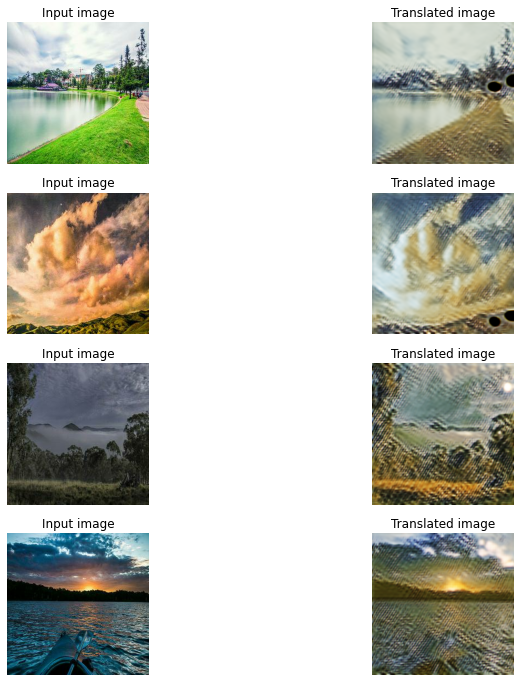

300/300 [==============================] - 178s 407ms/step - G_loss_(Monet): 4.1453 - F_loss_(Photo): 4.4256 - D_X_loss_(Photo): 0.5953 - D_Y_loss_(Monet): 0.5985
Epoch 2/20
300/300 [==============================] - 116s 387ms/step - G_loss_(Monet): 4.0617 - F_loss_(Photo): 4.4465 - D_X_loss_(Photo): 0.5828 - D_Y_loss_(Monet): 0.5911
Epoch 3/20
300/300 [==============================] - 116s 387ms/step - G_loss_(Monet): 4.1396 - F_loss_(Photo): 4.3352 - D_X_loss_(Photo): 0.5856 - D_Y_loss_(Monet): 0.5640
Epoch 4/20
300/300 [==============================] - 116s 387ms/step - G_loss_(Monet): 4.0709 - F_loss_(Photo): 4.3406 - D_X_loss_(Photo): 0.5614 - D_Y_loss_(Monet): 0.6108
Epoch 5/20
300/300 [==============================] - 116s 386ms/step - G_loss_(Monet): 4.0830 - F_loss_(Photo): 4.2230 - D_X_loss_(Photo): 0.6173 - D_Y_loss_(Monet): 0.5980
Epoch 6/20
300/300 [==============================] - ETA: 0s - G_loss_(Monet): 3.9482 - F_loss_(Photo): 4.0663 - D_X_loss_(Photo): 0.6078 - 

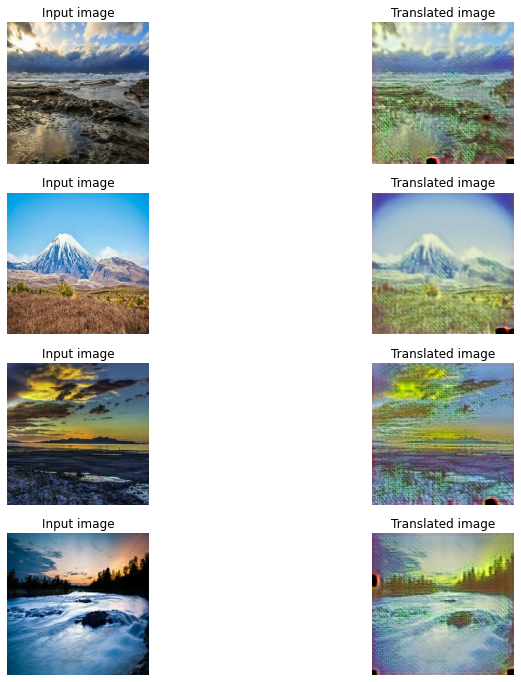

300/300 [==============================] - 117s 390ms/step - G_loss_(Monet): 3.9479 - F_loss_(Photo): 4.0648 - D_X_loss_(Photo): 0.6073 - D_Y_loss_(Monet): 0.6004
Epoch 7/20
300/300 [==============================] - 118s 391ms/step - G_loss_(Monet): 3.9972 - F_loss_(Photo): 4.0718 - D_X_loss_(Photo): 0.6049 - D_Y_loss_(Monet): 0.6059
Epoch 8/20
300/300 [==============================] - 117s 388ms/step - G_loss_(Monet): 3.9378 - F_loss_(Photo): 4.0974 - D_X_loss_(Photo): 0.6043 - D_Y_loss_(Monet): 0.6232
Epoch 9/20
300/300 [==============================] - 117s 389ms/step - G_loss_(Monet): 3.8253 - F_loss_(Photo): 3.8763 - D_X_loss_(Photo): 0.6147 - D_Y_loss_(Monet): 0.6172
Epoch 10/20
300/300 [==============================] - 117s 388ms/step - G_loss_(Monet): 3.8033 - F_loss_(Photo): 3.9203 - D_X_loss_(Photo): 0.6055 - D_Y_loss_(Monet): 0.6247
Epoch 11/20
300/300 [==============================] - ETA: 0s - G_loss_(Monet): 3.7191 - F_loss_(Photo): 3.8237 - D_X_loss_(Photo): 0.6156 

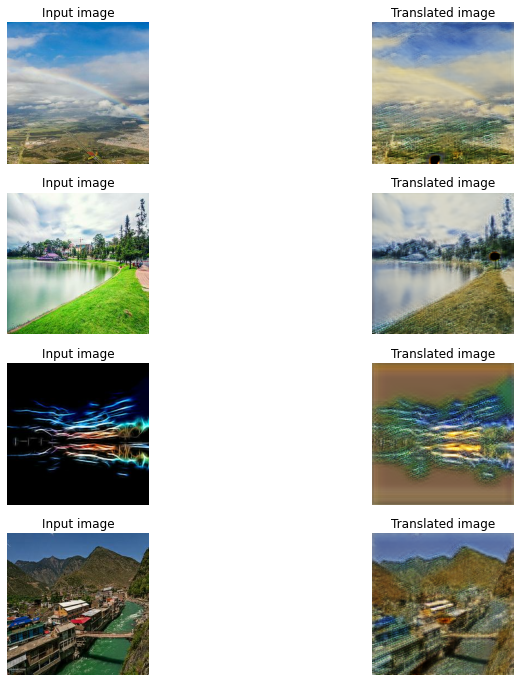

300/300 [==============================] - 118s 392ms/step - G_loss_(Monet): 3.7177 - F_loss_(Photo): 3.8210 - D_X_loss_(Photo): 0.6152 - D_Y_loss_(Monet): 0.6222
Epoch 12/20
300/300 [==============================] - 117s 388ms/step - G_loss_(Monet): 3.7294 - F_loss_(Photo): 3.9187 - D_X_loss_(Photo): 0.6179 - D_Y_loss_(Monet): 0.6149
Epoch 13/20
300/300 [==============================] - 117s 388ms/step - G_loss_(Monet): 3.6627 - F_loss_(Photo): 3.8049 - D_X_loss_(Photo): 0.6180 - D_Y_loss_(Monet): 0.6110
Epoch 14/20
300/300 [==============================] - 117s 389ms/step - G_loss_(Monet): 3.6754 - F_loss_(Photo): 3.7955 - D_X_loss_(Photo): 0.6359 - D_Y_loss_(Monet): 0.6150
Epoch 15/20
300/300 [==============================] - 117s 388ms/step - G_loss_(Monet): 3.6653 - F_loss_(Photo): 3.7571 - D_X_loss_(Photo): 0.6196 - D_Y_loss_(Monet): 0.6183
Epoch 16/20
300/300 [==============================] - ETA: 0s - G_loss_(Monet): 3.6560 - F_loss_(Photo): 3.8270 - D_X_loss_(Photo): 0.62

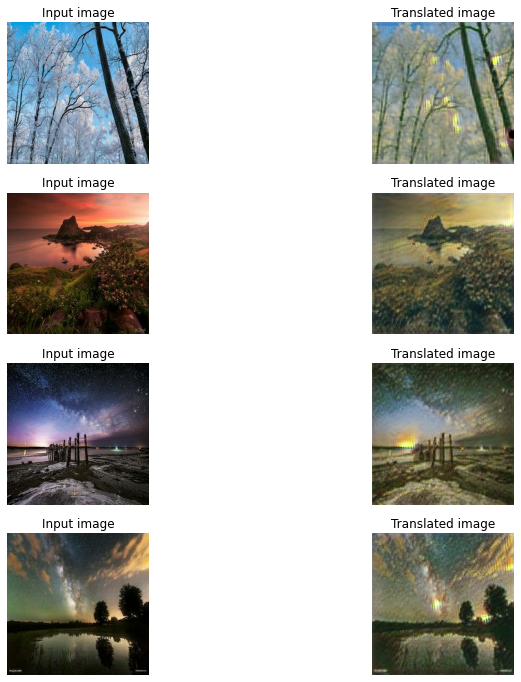

300/300 [==============================] - 118s 392ms/step - G_loss_(Monet): 3.6546 - F_loss_(Photo): 3.8349 - D_X_loss_(Photo): 0.6198 - D_Y_loss_(Monet): 0.6481
Epoch 17/20
300/300 [==============================] - 118s 391ms/step - G_loss_(Monet): 3.5961 - F_loss_(Photo): 3.8398 - D_X_loss_(Photo): 0.6140 - D_Y_loss_(Monet): 0.6245
Epoch 18/20
300/300 [==============================] - 118s 393ms/step - G_loss_(Monet): 3.5500 - F_loss_(Photo): 3.8074 - D_X_loss_(Photo): 0.6202 - D_Y_loss_(Monet): 0.6488
Epoch 19/20
300/300 [==============================] - 117s 389ms/step - G_loss_(Monet): 3.4375 - F_loss_(Photo): 3.7891 - D_X_loss_(Photo): 0.6180 - D_Y_loss_(Monet): 0.6341
Epoch 20/20
300/300 [==============================] - 117s 389ms/step - G_loss_(Monet): 3.4826 - F_loss_(Photo): 3.9453 - D_X_loss_(Photo): 0.6113 - D_Y_loss_(Monet): 0.6446


In [ ]:
# Create, compile, and train the CycleGAN model
cycle_gan_model = CycleGan(
    generator_G=gen_G, 
    generator_F=gen_F, 
    discriminator_X=disc_X, 
    discriminator_Y=disc_Y
)

cycle_gan_model.compile(
    gen_G_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_F_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_X_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    disc_Y_optimizer=keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss_fn,
    disc_loss_fn=discriminator_loss_fn,
)

cycle_gan_model.fit(
    tf.data.Dataset.zip((photo_ds, monet_ds)),
    epochs=20,
    callbacks=[plotter]
)


---
# Generate "fake" Monets for Kaggle submission

Competitions must be in a .zip archive and contain 7k-10k .jpg files.   I will use the 7038 training set photos to generate 7038 fake Monets.  The submission images will need to have their pixel values scaled from [-1,1] to [0,255].

In [ ]:
# modified from https://www.kaggle.com/code/dimitreoliveira/introduction-to-cyclegan-monet-paintings/notebook
import PIL
def predict_and_save(input_ds, generator_model, output_path, max_images=9001):
    i = 0
    for img in input_ds:
        prediction = generator_model(img, training=False)[0].numpy() # make prediction
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)   # re-scale
        im = PIL.Image.fromarray(prediction)
        im.save(f'{output_path}{str(i)}.jpg')
        i += 1
        if i == max_images:
            break

In [ ]:
os.makedirs('../images/') # Create folder to save generated images
predict_and_save(photo_ds, gen_G, '../images/', max_images=10)

In [ ]:
import shutil
shutil.make_archive("../images/", "zip", "../images") # Colab path
# shutil.make_archive('/kaggle/working/images/', 'zip', '../images') # Kaggle path
print(f"Generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

---
# Discussion

For this project, I modified the CycleGAN implementation from the [Keras documentation](https://keras.io/examples/generative/cyclegan/)


### Key alterations that **improved** the model's performance:
* adversarial loss functions: MSE --> BCE
* Generator upsampling blocks: conv2dtransposed --> resizing
* activation functions: ReLU --> Leaky ReLU

### Alterations that did **not** have a clear benefit:
* increased batch size
* more training epochs: 
* convolution kernel size: 3x3 --> 4x4



The modification that had the largest qualitative impact on the model was changing the upsampling method.

Initial results showed that nearly every generated image had pronounced "checkerboard" artifacts throughout the image.  These gridlines are apparently a common problem among GAN models, but nonetheless, they don't belong anywhere near a Monet painting.  

[This article](https://distill.pub/2016/deconv-checkerboard/) recommended changing the upsampling method to reduce the checkerboard artifacts.  Specifically, I changed `Conv2DTranspose(strides=2)` to `tf.image.resize(size=img_size*2)` followed by `Conv2DTranspose(strides=1)`.  This didn't eliminate artifacts, but at least it made them curvy and irregular. The curvier artifacts aren't desirable, but they're a better match to Monet's style than the checkerboard pattern gridlines.

<br>
<h4>Checkerboard artifacts when upsampling via transposed convolution (stride=2) </h4>

![1_20epk_stride](https://raw.githubusercontent.com/r-quillen/Monet-CycleGAN/main/1_20epk_stride.jpg) ![2_20epk_stride](https://raw.githubusercontent.com/r-quillen/Monet-CycleGAN/main/2_20epk_stride.jpg) ![3_20epk_stride](https://raw.githubusercontent.com/r-quillen/Monet-CycleGAN/main/3_20epk_stride.jpg) 

<br>
<h4>Artifacts when upsampling via resize </h4>

![1_20epk_resize](https://raw.githubusercontent.com/r-quillen/Monet-CycleGAN/main/1_20epk_resize.jpg) ![2_20epk_resize](https://raw.githubusercontent.com/r-quillen/Monet-CycleGAN/main/2_20epk_resize.jpg) ![3_20epk_resize](https://raw.githubusercontent.com/r-quillen/Monet-CycleGAN/main/3_20epk_resize.jpg) 









# Summary table
Note: due to Kaggle's weekly GPU and daily submission limits, I wasn't able to test all combinations of these parameters

| upsampling | activation fn | adversarial loss fn | epochs | MiFID |
| ---        |       ---     |       ---           |   ---  |  ---  |
| resize --> stride=1 | ReLU |    BCE              | 20     | 71.75 |
| resize --> stride=1 | Leaky ReLU |    BCE              | 20     | **68.35** |
| resize --> stride=1 | Leaky ReLU |    BCE              | 40     | 85.07 |
| stride=2 | Leaky ReLU |    BCE              | 20     | 76.10 |
| resize --> stride=1 | Leaky ReLU |    MSE              | 20     | 82.37 |



# Future Improvements

* The encoder and decoder blocks of the generators are excellent places to try different architectures.  As with CNN models, it is worth considering the addition of skip connections between layers.


* Research into GAN training has shown that GANs often suffer from discriminators being too successful. Adding small amounts of Gaussian noise to discriminator inputs is one recommended practice to prevent this.  "Soft labeling" of the "real" images is another practice worth trying.

# References

Keras CycleGAN implementation
https://keras.io/examples/generative/cyclegan/

Checkerboard artifact explanation
https://distill.pub/2016/deconv-checkerboard/

Original CycleGAN paper
https://arxiv.org/abs/1703.10593

